In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy             as np
import h5py
import sys
from matplotlib import cm
sys.path.append('/home/jovyan/home/illstack/CAMELS_example')
import profile_functions


home='/home/jovyan/home/illstack/CAMELS_example/'
h=0.6711

In [2]:
def extract(simulation,snap): #extract the quantities,adjust as necessary
    file='/home/jovyan/Simulations/'+suite+'/'+simulation+'/snap_'+snap+'.hdf5'
    b=h5py.File(file,'r')
    z=b['/Header'].attrs[u'Redshift']
    
    stacks=np.load(home+'Batch_NPZ_files_with_CM/'+suite+'/'+suite+'_'+simulation+'_'+snap+'.npz'%z,allow_pickle=True)
    val            = stacks['val']
    val_dens       = val[0,:]
    val_pres       = val[1,:]
    bins           = stacks['nbins']
    r              = stacks['r']
    nprofs         = stacks['nprofs']
    mh             = stacks['M_Crit200'] #units 1e10 Msol/h, M200c
    rh             = stacks['R_Crit200'] #R200c
    return z,val_dens,bins,r,val_pres,nprofs,mh,rh

def mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins):
    idx=np.where((mh > mh_low) & (mh < mh_high))
    mh,rh=mh[idx],rh[idx]
    nprofs=len(mh)
    val_pres,val_dens=val_pres[idx,:],val_dens[idx,:]
    val_pres,val_dens=np.reshape(val_pres,(nprofs,bins)),np.reshape(val_dens,(nprofs,bins))
    return mh,rh,val_pres,val_dens,nprofs

def correct(z,h,mh,rh,val_dens,val_pres,r): #correct all h and comoving factors
    comoving_factor=1.0+z
    mh       *= 1e10
    mh       /= h
    rh       /= h
    rh      /= comoving_factor
    val_dens *= 1e10 * h**2
    val_pres *= 1e10 * h**2
    val_pres /= (3.086e16*3.086e16)
    val_dens *= comoving_factor**3
    val_pres *= comoving_factor**3
    #for unscaled
    r /= h
    r /= comoving_factor
    return mh,rh,val_dens,val_pres,r

Let's make profiles for mean and median density and pressure for each suite and feedback parameter. We'll start with the 4 mass bins we currently have for the emulator: 12-12.2, 12.2-12.4, 12.4-12.8, 12.8-13.2.

In [4]:
snap='024'

mass_str_arr=['12-12.2','12.2-12.4','12.4-12.8','12.8-13.2']

mh_low_arr=[10**12.,10**12.2+.1,10**12.4+.1,10**12.8+.1]
mh_high_arr=[10**12.2,10**12.4,10**12.8,10**13.2]
print(mh_low_arr)
print(mh_high_arr)

[1000000000000.0, 1584893192461.211, 2511886431509.682, 6309573444802.042]
[1584893192461.1108, 2511886431509.582, 6309573444801.942, 15848931924611.11]


# 1. TNG, $A_{SN1}$

In [25]:
suite='IllustrisTNG'
  
nums=np.linspace(22,32,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

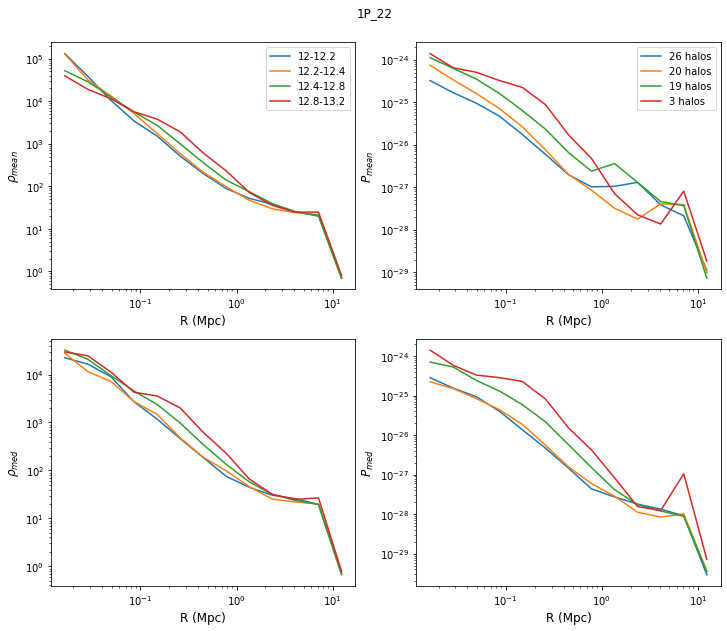

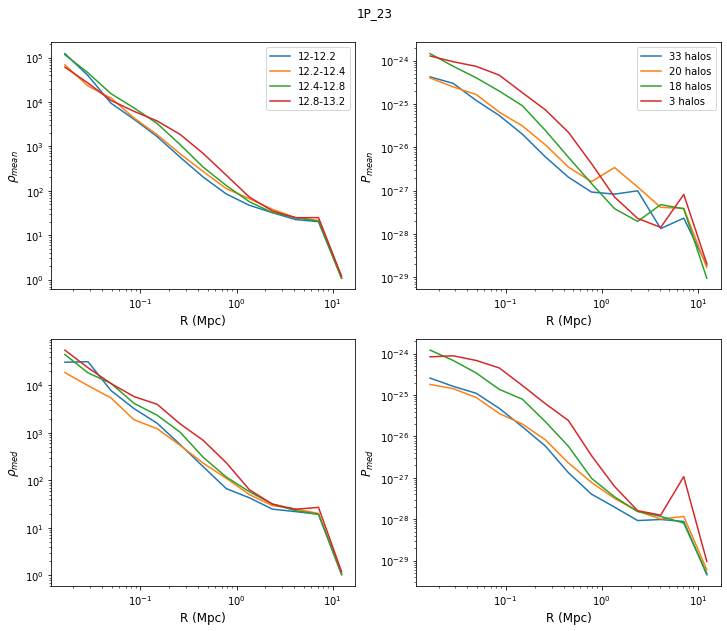

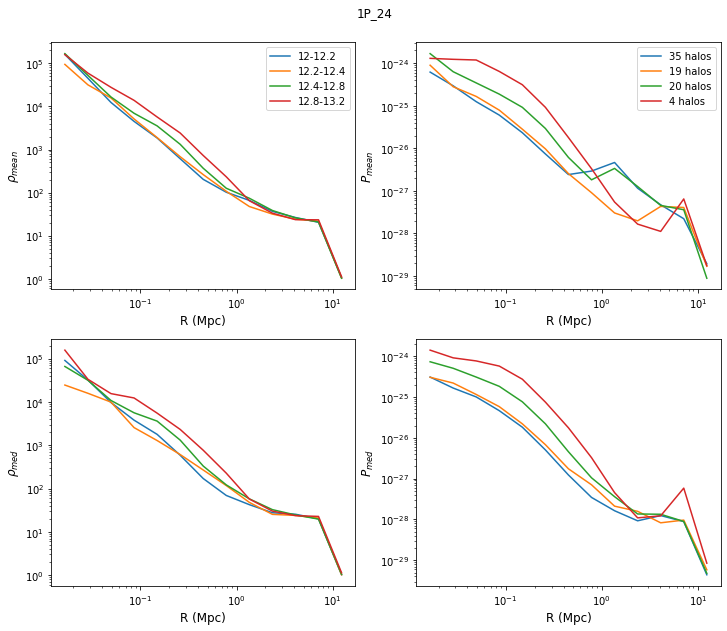

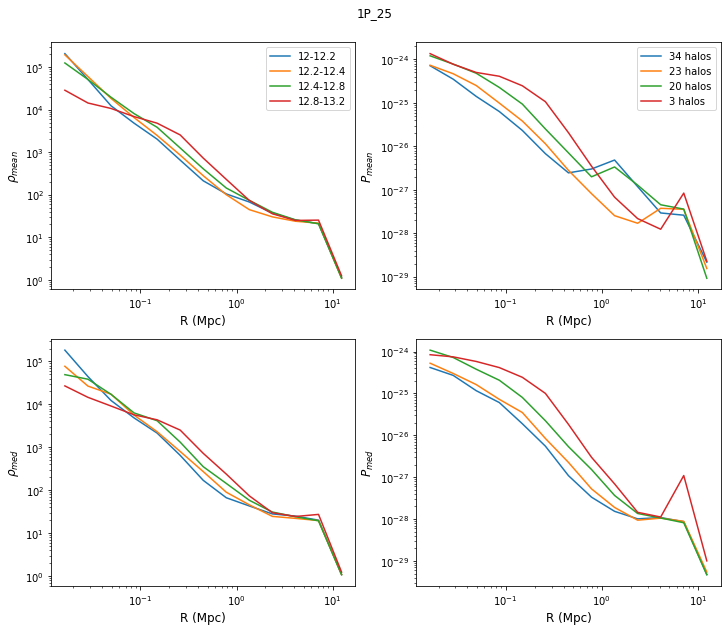

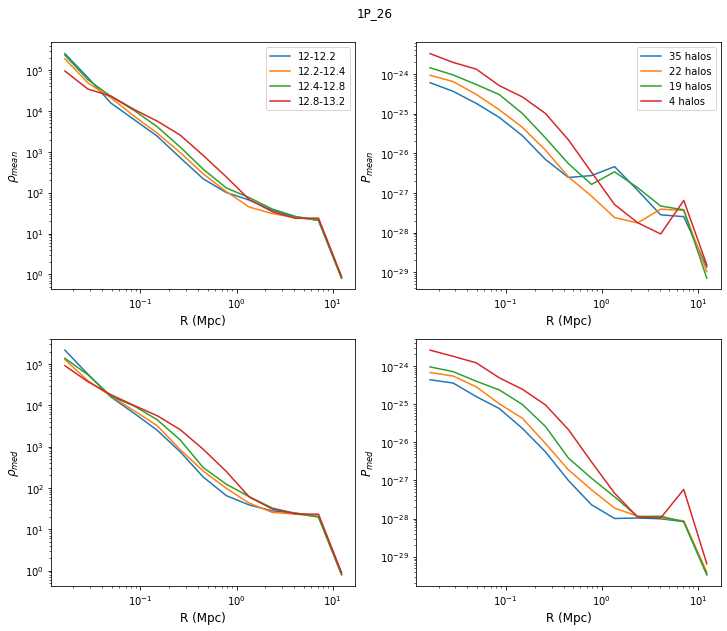

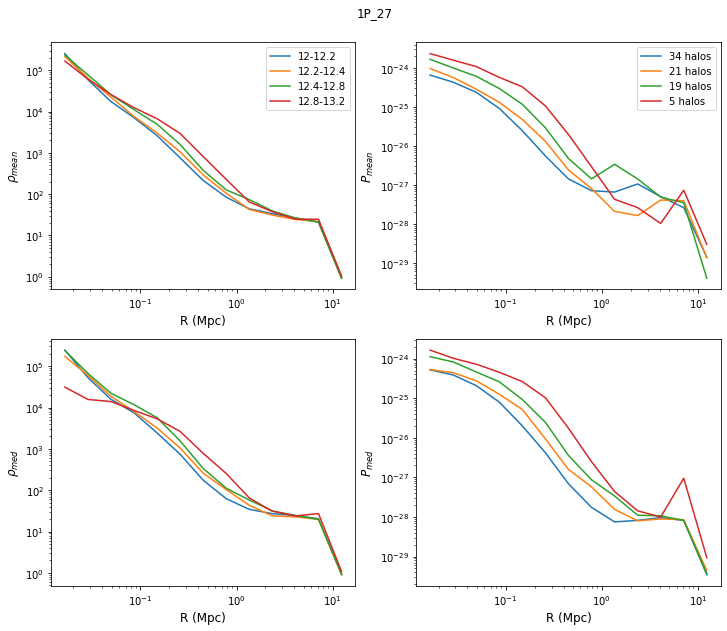

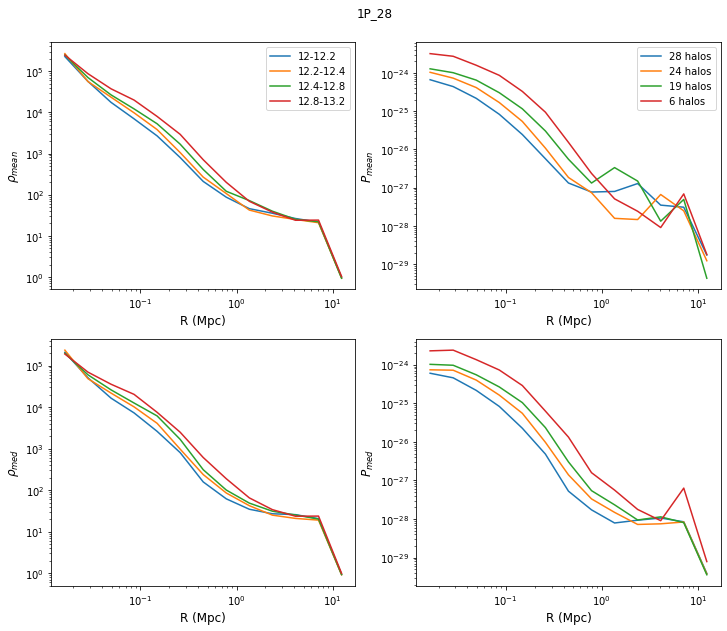

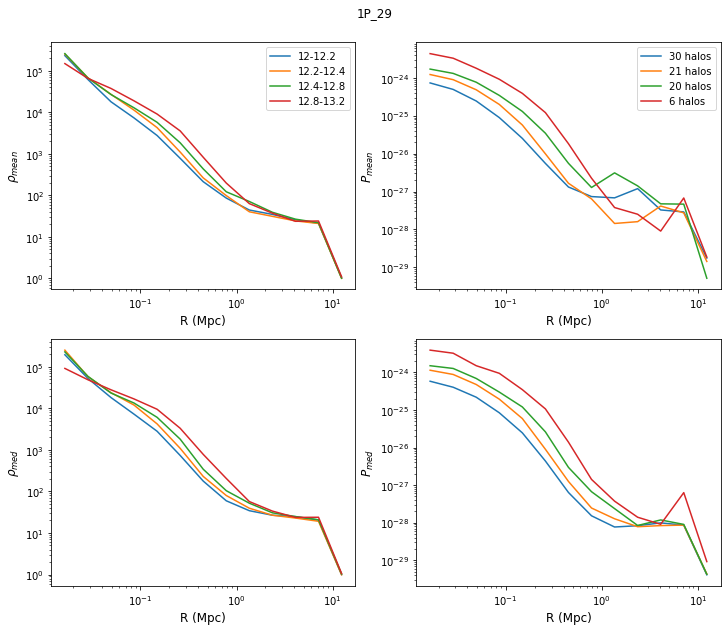

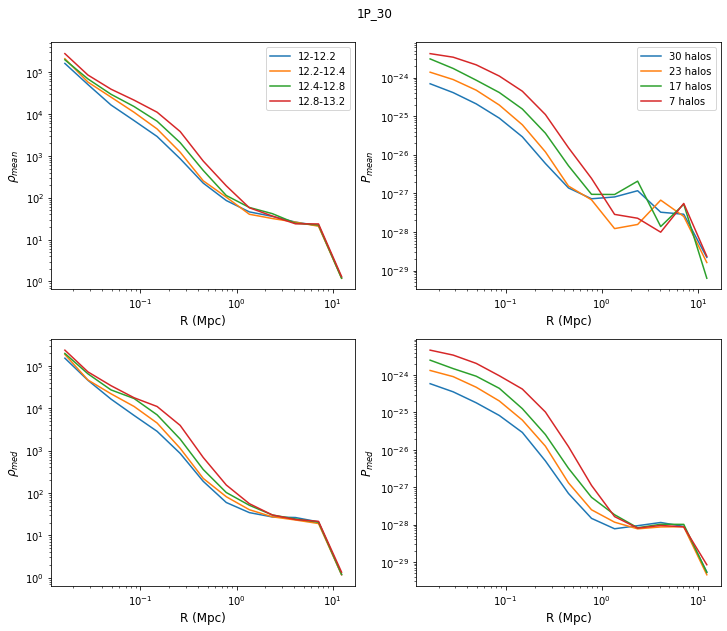

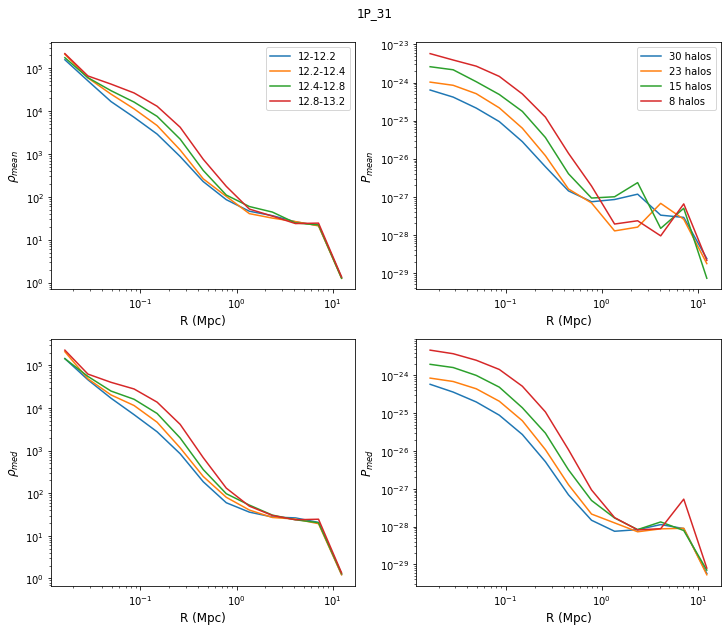

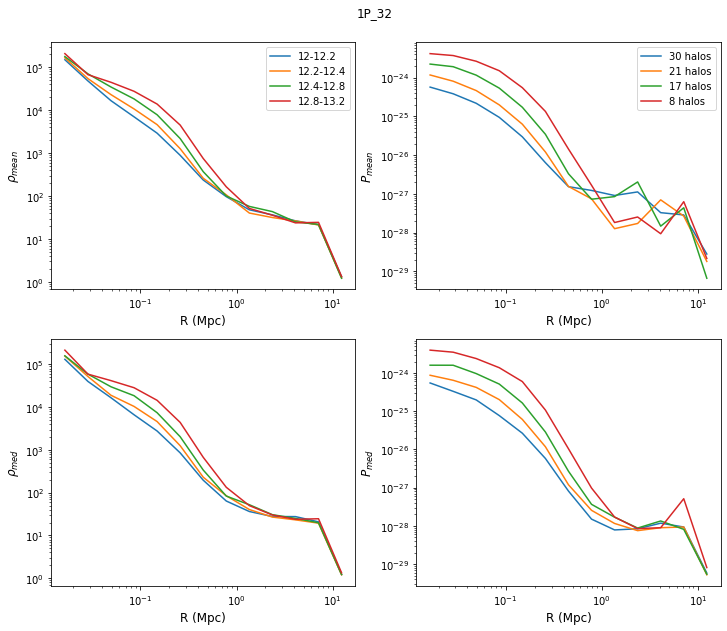

In [26]:
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)
    
    fig,axes=plt.subplots(2,2,figsize=(12,10))
    ax0=axes[0,0]
    ax1=axes[0,1]
    ax2=axes[1,0]
    ax3=axes[1,1]
    for m in np.arange(len(mh_low_arr)):
        mh_low=mh_low_arr[m]
        mh_high=mh_high_arr[m]
        mass_str=mass_str_arr[m]
        mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
        r_mpc=r/1.e3
            
        r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
        r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(0.01,r_mpc_cut,val_densm)
        r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
        r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(0.01,r_mpc_cut,val_presm)
                        
        mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
        mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
        median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
        median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
        errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
        errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
        ax0.loglog(r_mpc_cut2,mean_unnorm_densm,label=mass_str)
        ax1.loglog(r_mpc_cut2,mean_unnorm_presm,label='%i halos'%nprofsm)
        ax2.loglog(r_mpc_cut2,median_unnorm_densm)
        ax3.loglog(r_mpc_cut2,median_unnorm_presm)
    ax0.set_xlabel('R (Mpc)',size=12)
    ax1.set_xlabel('R (Mpc)',size=12)
    ax2.set_xlabel('R (Mpc)',size=12)
    ax3.set_xlabel('R (Mpc)',size=12)
    ax0.set_ylabel(r'$\rho_{mean}$',size=12)
    ax1.set_ylabel(r'$P_{mean}$',size=12)
    ax2.set_ylabel(r'$\rho_{med}$',size=12)
    ax3.set_ylabel(r'$P_{med}$',size=12)
    ax0.legend()
    ax1.legend()
    plt.suptitle(sim,y=0.93)
    plt.show()

Result: It seems that the intermediate parts of $\rho_{med}$ and $\rho_{mean}$, and the inner-intermediate parts of $P_{med}$ and $P_{mean}$ are well-behaved in some kind of monotonic order. The outer profiles get a little more disorganized, especially for the pressure profiles, and (maybe) increasingly jagged for the higher mass bins (probably due to the low number of halos).

Let's try different mass bins, and for lower masses. The original bins we had just don't have enough halos in them. So let's try mass bins 11-11.5-12-12.3-13.1

In [68]:
mass_str_arr=['11-11.5','11.5-12','12-12.3','12.3-13.1']
mh_low_arr=[10**11.,10**11.5+0.1,10**12.+0.1,10**12.3+.1]
mh_high_arr=[10**11.5,10**12.,10**12.3,10**13.1]

# 1. TNG, $A_{SN1}$

In [56]:
suite='IllustrisTNG'

vary_str='ASN1'
vary=np.array([0.25000,0.32988,0.43528,0.57435,0.75786,1.00000,1.31951,1.74110,2.29740,3.03143,4.00000])
  
nums=np.linspace(22,32,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

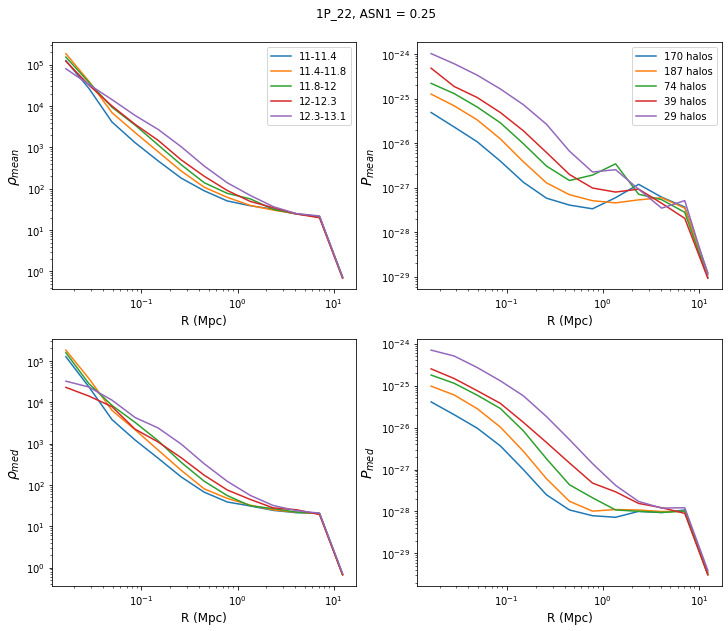

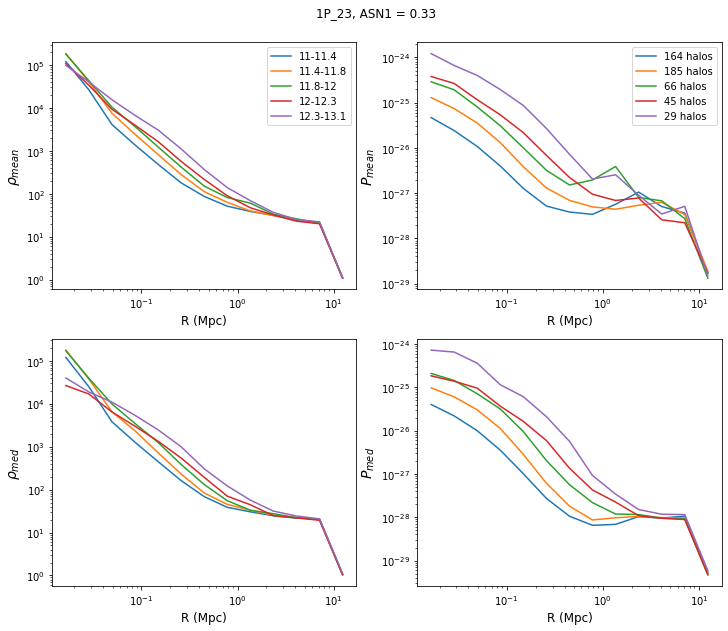

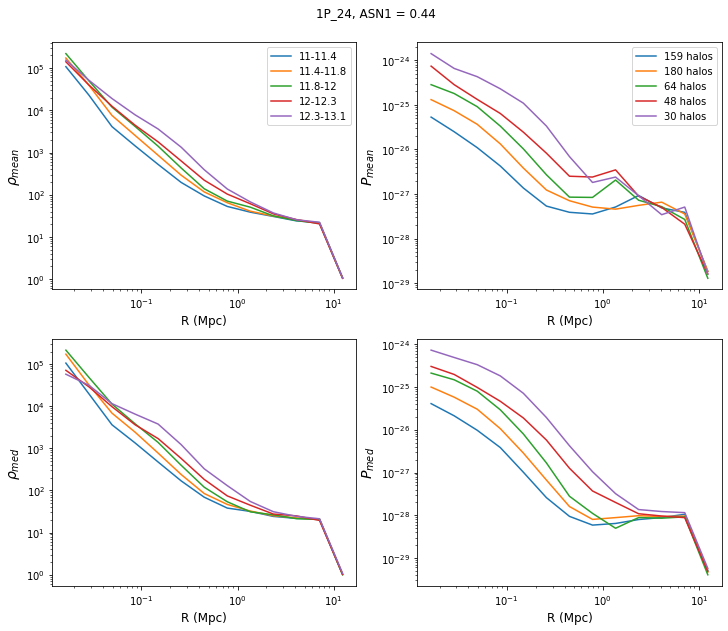

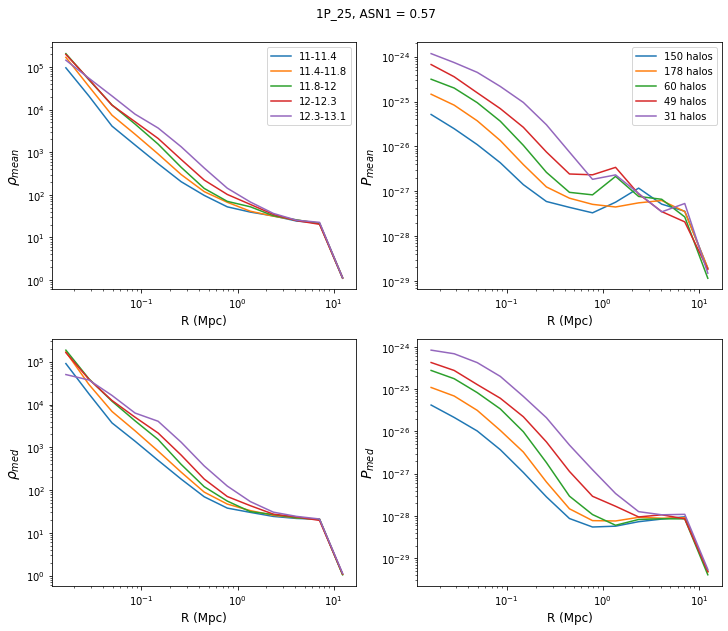

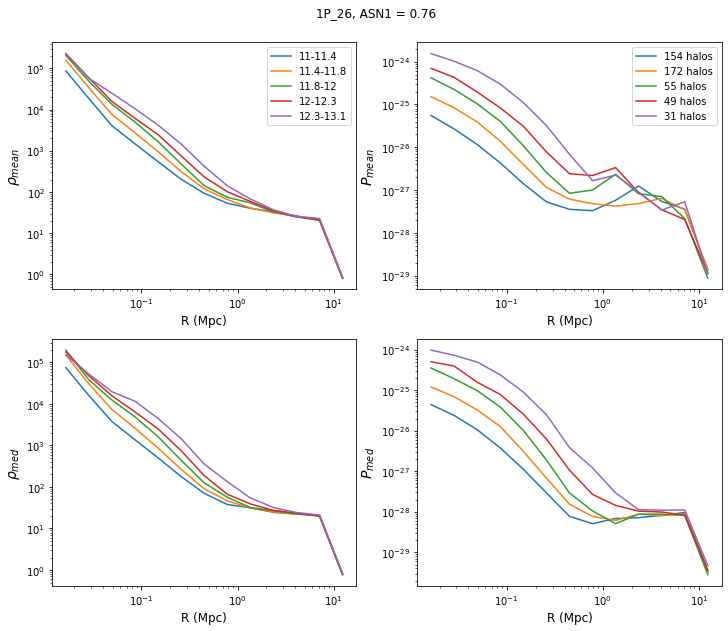

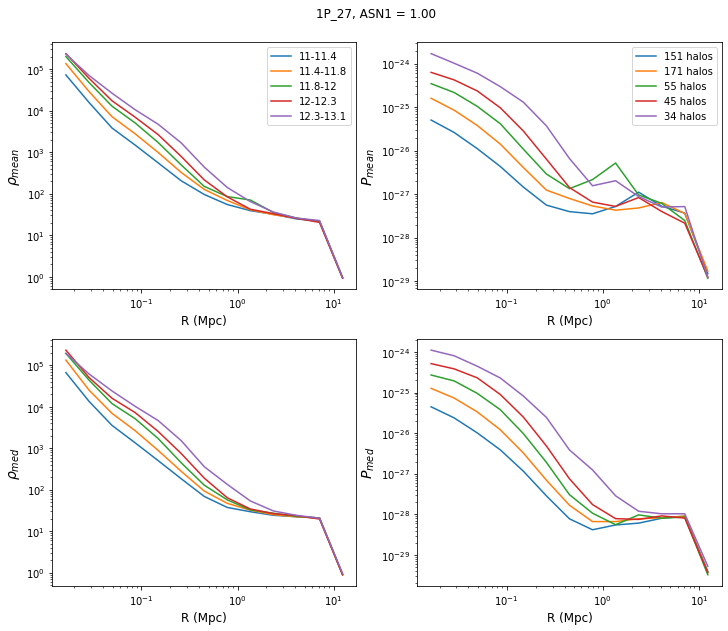

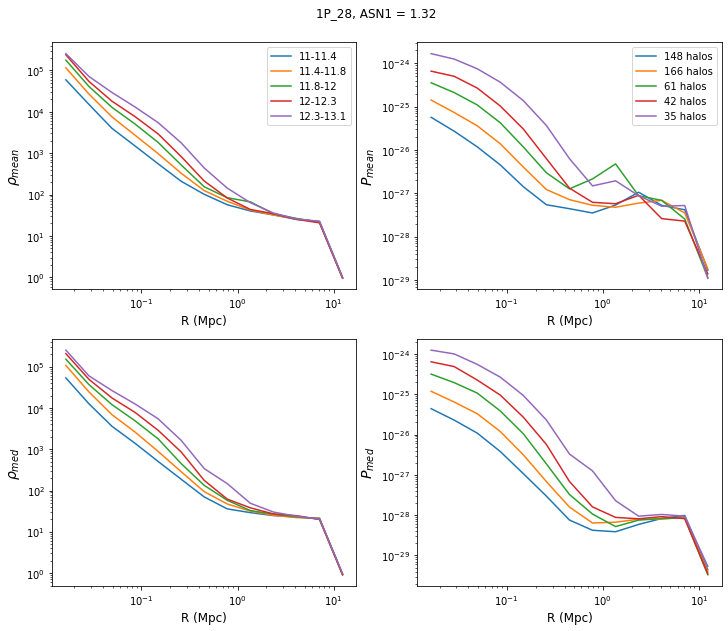

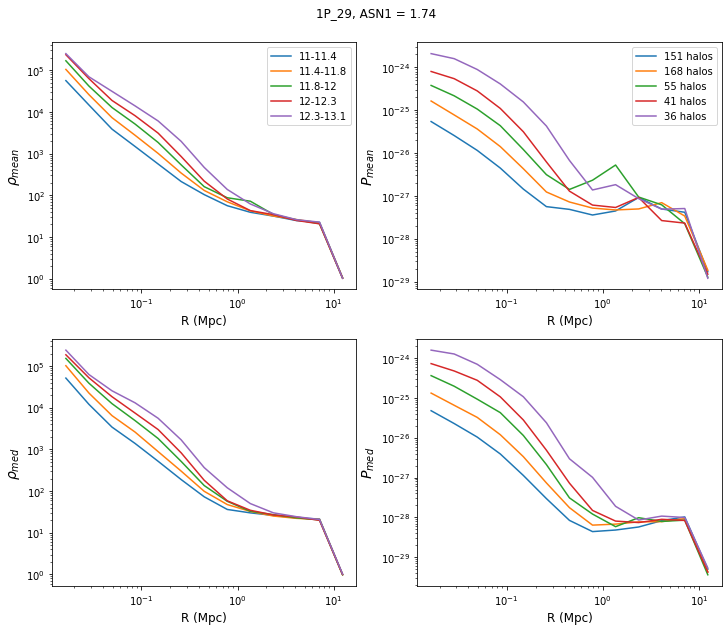

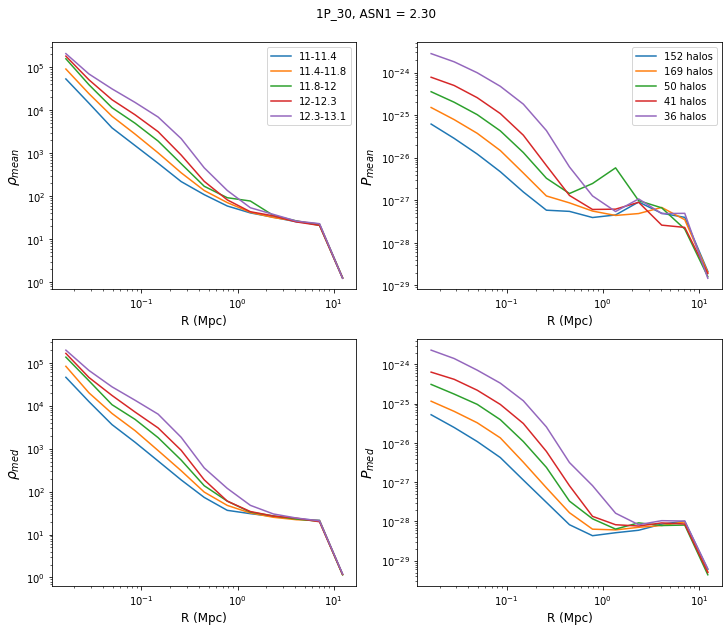

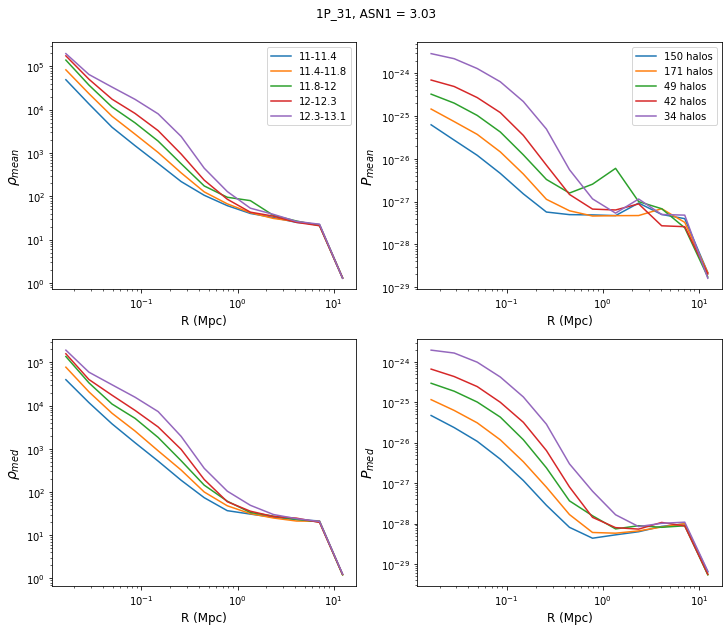

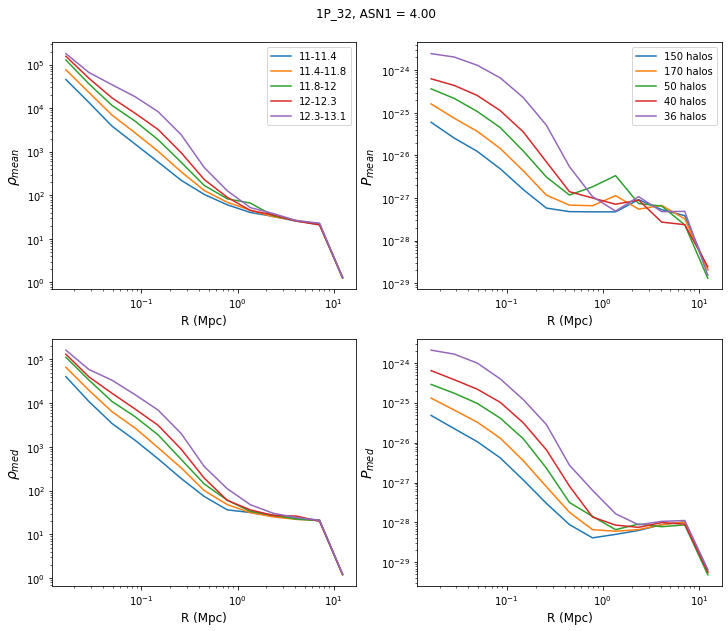

In [57]:
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)
    
    fig,axes=plt.subplots(2,2,figsize=(12,10))
    ax0=axes[0,0]
    ax1=axes[0,1]
    ax2=axes[1,0]
    ax3=axes[1,1]
    for m in np.arange(len(mh_low_arr)):
        mh_low=mh_low_arr[m]
        mh_high=mh_high_arr[m]
        mass_str=mass_str_arr[m]
        mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
        r_mpc=r/1.e3
            
        r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
        r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(0.01,r_mpc_cut,val_densm)
        r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
        r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(0.01,r_mpc_cut,val_presm)
                        
        mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
        mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
        median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
        median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
        errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
        errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
        ax0.loglog(r_mpc_cut2,mean_unnorm_densm,label=mass_str)
        ax1.loglog(r_mpc_cut2,mean_unnorm_presm,label='%i halos'%nprofsm)
        ax2.loglog(r_mpc_cut2,median_unnorm_densm)
        ax3.loglog(r_mpc_cut2,median_unnorm_presm)
    ax0.set_xlabel('R (Mpc)',size=12)
    ax1.set_xlabel('R (Mpc)',size=12)
    ax2.set_xlabel('R (Mpc)',size=12)
    ax3.set_xlabel('R (Mpc)',size=12)
    ax0.set_ylabel(r'$\rho_{mean}$',size=14)
    ax1.set_ylabel(r'$P_{mean}$',size=14)
    ax2.set_ylabel(r'$\rho_{med}$',size=14)
    ax3.set_ylabel(r'$P_{med}$',size=14)
    ax0.legend()
    ax1.legend()
    plt.suptitle('%s, %s = %.2f'%(sim,vary_str,vary[j]),y=0.93)
    plt.savefig('./Mass_bins/mass_bins_'+suite+'_'+sim+'.png')
    plt.show()

Ok now let's just focus on a single mass bin for each feedback parameter value.

# 1. TNG, $A_{SN1}$

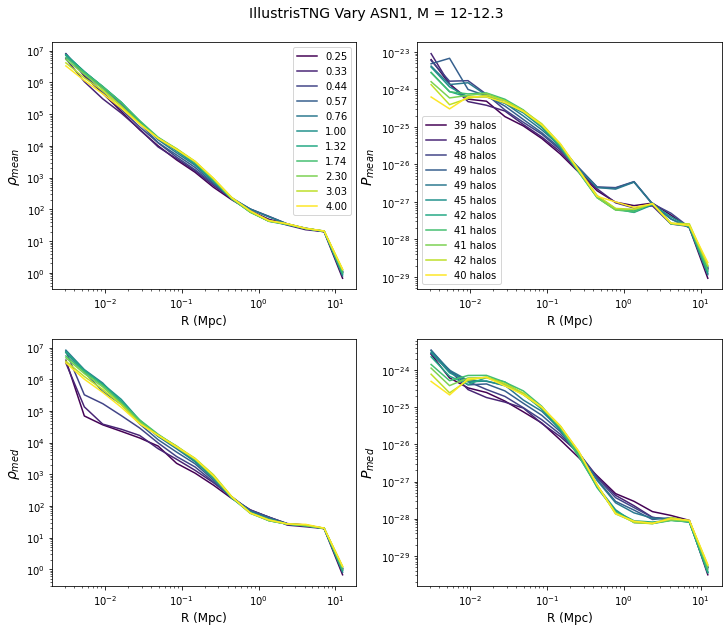

In [77]:
mass_str='12-12.3'
mh_low=10**12.+.1
mh_high=10**12.3

suite='IllustrisTNG'

vary_str='ASN1'
vary=np.array([0.25000,0.32988,0.43528,0.57435,0.75786,1.00000,1.31951,1.74110,2.29740,3.03143,4.00000])
  
cmap=cm.get_cmap('viridis',len(vary))
colors=cmap.colors

nums=np.linspace(22,32,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

fig,axes=plt.subplots(2,2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)

    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
    r_mpc=r/1.e3
            
    r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
    r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(2.e-3,r_mpc_cut,val_densm)
    r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
    r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(2.e-3,r_mpc_cut,val_presm)
                        
    mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
    mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
    median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
    median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
    errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
    errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
    ax0.loglog(r_mpc_cut2,mean_unnorm_densm,color=colors[j],label='%.2f'%(vary[j]))
    ax1.loglog(r_mpc_cut2,mean_unnorm_presm,color=colors[j],label='%i halos'%nprofsm)
    ax2.loglog(r_mpc_cut2,median_unnorm_densm,color=colors[j])
    ax3.loglog(r_mpc_cut2,median_unnorm_presm,color=colors[j])
ax0.set_xlabel('R (Mpc)',size=12)
ax1.set_xlabel('R (Mpc)',size=12)
ax2.set_xlabel('R (Mpc)',size=12)
ax3.set_xlabel('R (Mpc)',size=12)
ax0.set_ylabel(r'$\rho_{mean}$',size=14)
ax1.set_ylabel(r'$P_{mean}$',size=14)
ax2.set_ylabel(r'$\rho_{med}$',size=14)
ax3.set_ylabel(r'$P_{med}$',size=14)
ax0.legend()
ax1.legend()
plt.suptitle('%s Vary %s, M = %s'%(suite,vary_str,mass_str),y=0.93,size=14)
plt.savefig('./Mass_bins/vary_'+vary_str+'_'+suite+'_M_'+mass_str+'.png')
plt.show()

# 2. TNG, $A_{AGN1}$

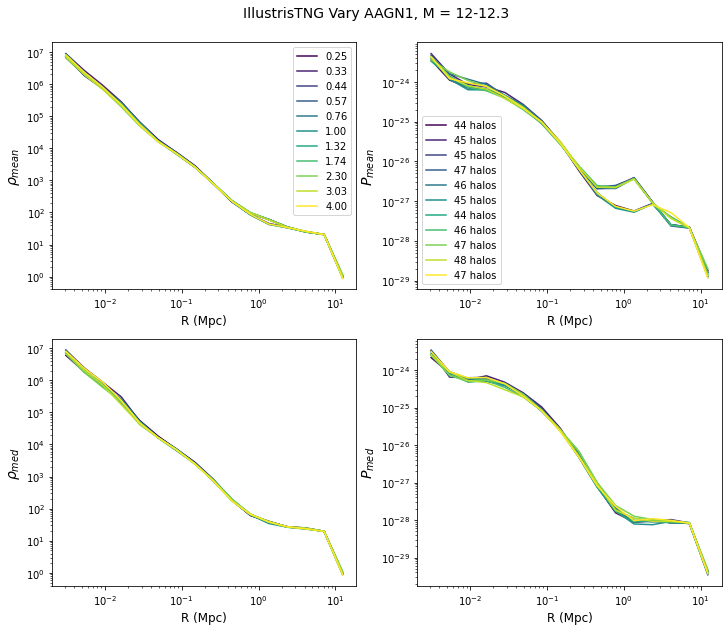

In [78]:
mass_str='12-12.3'
mh_low=10**12.+.1
mh_high=10**12.3

suite='IllustrisTNG'

vary_str='AAGN1'
vary=np.array([0.25000,0.32988,0.43528,0.57435,0.75786,1.00000,1.31951,1.74110,2.29740,3.03143,4.00000])
  
cmap=cm.get_cmap('viridis',len(vary))
colors=cmap.colors

nums=np.linspace(33,43,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

fig,axes=plt.subplots(2,2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)

    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
    r_mpc=r/1.e3
            
    r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
    r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(2.e-3,r_mpc_cut,val_densm)
    r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
    r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(2.e-3,r_mpc_cut,val_presm)
                        
    mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
    mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
    median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
    median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
    errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
    errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
    ax0.loglog(r_mpc_cut2,mean_unnorm_densm,color=colors[j],label='%.2f'%(vary[j]))
    ax1.loglog(r_mpc_cut2,mean_unnorm_presm,color=colors[j],label='%i halos'%nprofsm)
    ax2.loglog(r_mpc_cut2,median_unnorm_densm,color=colors[j])
    ax3.loglog(r_mpc_cut2,median_unnorm_presm,color=colors[j])
ax0.set_xlabel('R (Mpc)',size=12)
ax1.set_xlabel('R (Mpc)',size=12)
ax2.set_xlabel('R (Mpc)',size=12)
ax3.set_xlabel('R (Mpc)',size=12)
ax0.set_ylabel(r'$\rho_{mean}$',size=14)
ax1.set_ylabel(r'$P_{mean}$',size=14)
ax2.set_ylabel(r'$\rho_{med}$',size=14)
ax3.set_ylabel(r'$P_{med}$',size=14)
ax0.legend()
ax1.legend()
plt.suptitle('%s Vary %s, M = %s'%(suite,vary_str,mass_str),y=0.93,size=14)
plt.savefig('./Mass_bins/vary_'+vary_str+'_'+suite+'_M_'+mass_str+'.png')
plt.show()

# 3. TNG, $A_{SN2}$

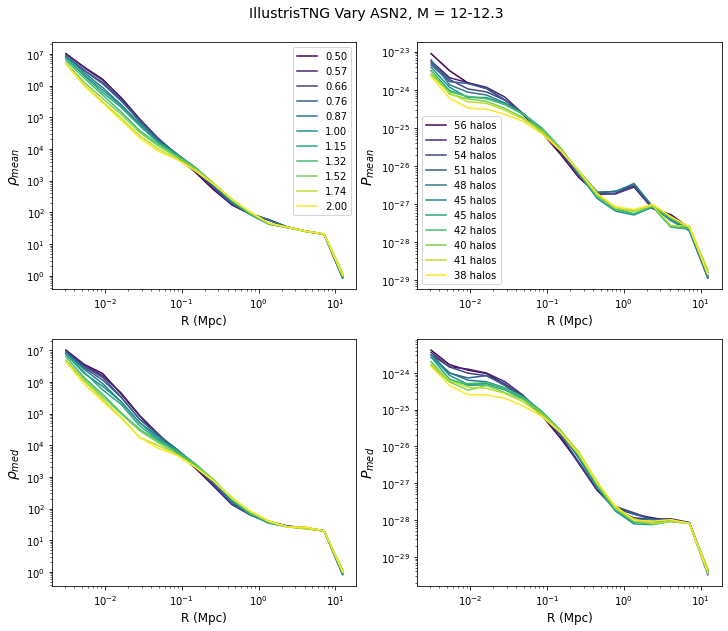

In [79]:
mass_str='12-12.3'
mh_low=10**12.+.1
mh_high=10**12.3

suite='IllustrisTNG'

vary_str='ASN2'
vary=np.array([0.50000,0.57435,0.65975,0.75786,0.87055,1.00000,1.14870,1.31951,1.51572,1.74110,2.00000])
 
cmap=cm.get_cmap('viridis',len(vary))
colors=cmap.colors

nums=np.linspace(44,54,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

fig,axes=plt.subplots(2,2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)

    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
    r_mpc=r/1.e3
            
    r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
    r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(2.e-3,r_mpc_cut,val_densm)
    r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
    r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(2.e-3,r_mpc_cut,val_presm)
                        
    mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
    mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
    median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
    median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
    errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
    errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
    ax0.loglog(r_mpc_cut2,mean_unnorm_densm,color=colors[j],label='%.2f'%(vary[j]))
    ax1.loglog(r_mpc_cut2,mean_unnorm_presm,color=colors[j],label='%i halos'%nprofsm)
    ax2.loglog(r_mpc_cut2,median_unnorm_densm,color=colors[j])
    ax3.loglog(r_mpc_cut2,median_unnorm_presm,color=colors[j])
ax0.set_xlabel('R (Mpc)',size=12)
ax1.set_xlabel('R (Mpc)',size=12)
ax2.set_xlabel('R (Mpc)',size=12)
ax3.set_xlabel('R (Mpc)',size=12)
ax0.set_ylabel(r'$\rho_{mean}$',size=14)
ax1.set_ylabel(r'$P_{mean}$',size=14)
ax2.set_ylabel(r'$\rho_{med}$',size=14)
ax3.set_ylabel(r'$P_{med}$',size=14)
ax0.legend()
ax1.legend()
plt.suptitle('%s Vary %s, M = %s'%(suite,vary_str,mass_str),y=0.93,size=14)
plt.savefig('./Mass_bins/vary_'+vary_str+'_'+suite+'_M_'+mass_str+'.png')
plt.show()

# 4. TNG, $A_{AGN2}$

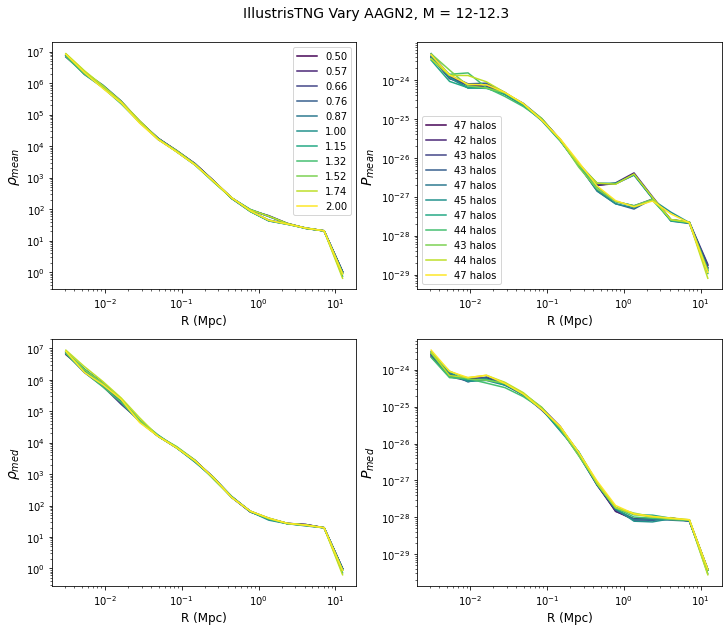

In [80]:
mass_str='12-12.3'
mh_low=10**12.+.1
mh_high=10**12.3

suite='IllustrisTNG'

vary_str='AAGN2'
vary=np.array([0.50000,0.57435,0.65975,0.75786,0.87055,1.00000,1.14870,1.31951,1.51572,1.74110,2.00000])
 
cmap=cm.get_cmap('viridis',len(vary))
colors=cmap.colors

nums=np.linspace(55,65,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

fig,axes=plt.subplots(2,2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)

    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
    r_mpc=r/1.e3
            
    r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
    r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(2.e-3,r_mpc_cut,val_densm)
    r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
    r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(2.e-3,r_mpc_cut,val_presm)
                        
    mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
    mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
    median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
    median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
    errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
    errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
    ax0.loglog(r_mpc_cut2,mean_unnorm_densm,color=colors[j],label='%.2f'%(vary[j]))
    ax1.loglog(r_mpc_cut2,mean_unnorm_presm,color=colors[j],label='%i halos'%nprofsm)
    ax2.loglog(r_mpc_cut2,median_unnorm_densm,color=colors[j])
    ax3.loglog(r_mpc_cut2,median_unnorm_presm,color=colors[j])
ax0.set_xlabel('R (Mpc)',size=12)
ax1.set_xlabel('R (Mpc)',size=12)
ax2.set_xlabel('R (Mpc)',size=12)
ax3.set_xlabel('R (Mpc)',size=12)
ax0.set_ylabel(r'$\rho_{mean}$',size=14)
ax1.set_ylabel(r'$P_{mean}$',size=14)
ax2.set_ylabel(r'$\rho_{med}$',size=14)
ax3.set_ylabel(r'$P_{med}$',size=14)
ax0.legend()
ax1.legend()
plt.suptitle('%s Vary %s, M = %s'%(suite,vary_str,mass_str),y=0.93,size=14)
plt.savefig('./Mass_bins/vary_'+vary_str+'_'+suite+'_M_'+mass_str+'.png')
plt.show()

# 5. SIMBA, $A_{SN1}$

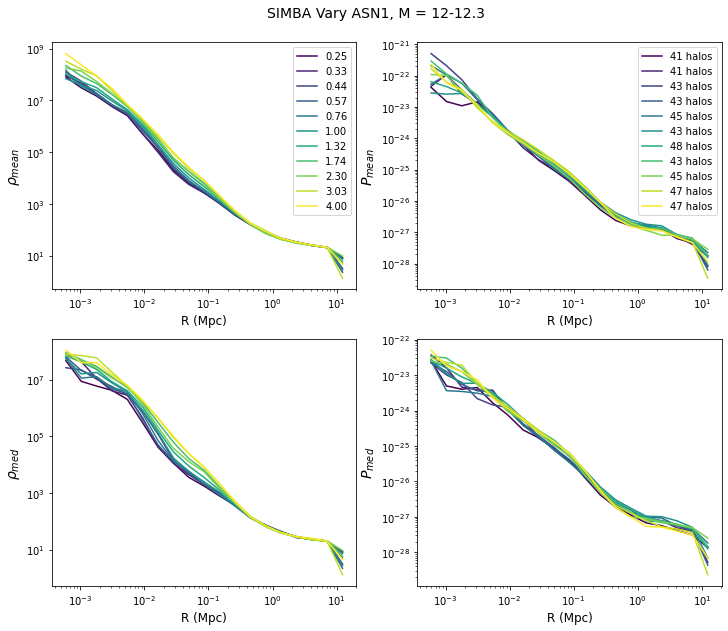

In [81]:
mass_str='12-12.3'
mh_low=10**12.+.1
mh_high=10**12.3

suite='SIMBA'

vary_str='ASN1'
vary=np.array([0.25000,0.32988,0.43528,0.57435,0.75786,1.00000,1.31951,1.74110,2.29740,3.03143,4.00000])
  
cmap=cm.get_cmap('viridis',len(vary))
colors=cmap.colors

nums=np.linspace(22,32,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

fig,axes=plt.subplots(2,2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)

    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
    r_mpc=r/1.e3
            
    r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
    r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(5.e-4,r_mpc_cut,val_densm)
    r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
    r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(5.e-4,r_mpc_cut,val_presm)
                        
    mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
    mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
    median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
    median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
    errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
    errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
    ax0.loglog(r_mpc_cut2,mean_unnorm_densm,color=colors[j],label='%.2f'%(vary[j]))
    ax1.loglog(r_mpc_cut2,mean_unnorm_presm,color=colors[j],label='%i halos'%nprofsm)
    ax2.loglog(r_mpc_cut2,median_unnorm_densm,color=colors[j])
    ax3.loglog(r_mpc_cut2,median_unnorm_presm,color=colors[j])
ax0.set_xlabel('R (Mpc)',size=12)
ax1.set_xlabel('R (Mpc)',size=12)
ax2.set_xlabel('R (Mpc)',size=12)
ax3.set_xlabel('R (Mpc)',size=12)
ax0.set_ylabel(r'$\rho_{mean}$',size=14)
ax1.set_ylabel(r'$P_{mean}$',size=14)
ax2.set_ylabel(r'$\rho_{med}$',size=14)
ax3.set_ylabel(r'$P_{med}$',size=14)
ax0.legend()
ax1.legend()
plt.suptitle('%s Vary %s, M = %s'%(suite,vary_str,mass_str),y=0.93,size=14)
plt.savefig('./Mass_bins/vary_'+vary_str+'_'+suite+'_M_'+mass_str+'.png')
plt.show()

# 6. SIMBA, $A_{AGN1}$

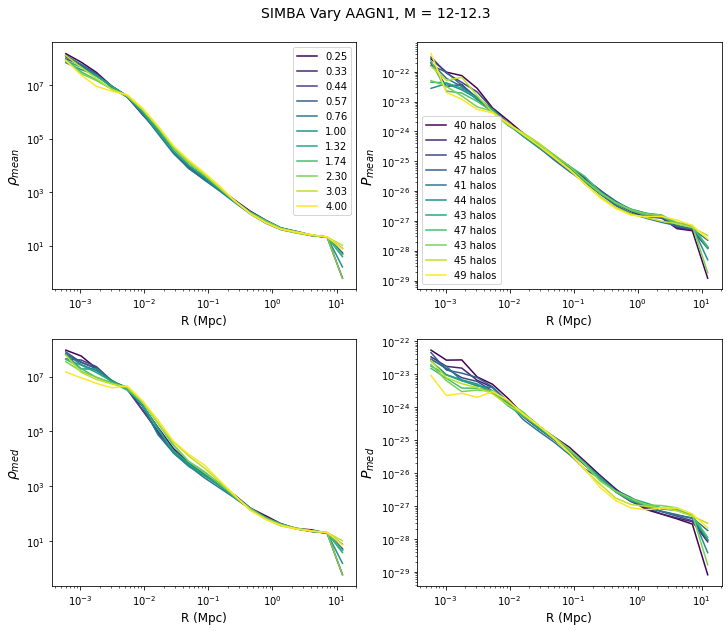

In [82]:
mass_str='12-12.3'
mh_low=10**12.+.1
mh_high=10**12.3

suite='SIMBA'

vary_str='AAGN1'
vary=np.array([0.25000,0.32988,0.43528,0.57435,0.75786,1.00000,1.31951,1.74110,2.29740,3.03143,4.00000])
  
cmap=cm.get_cmap('viridis',len(vary))
colors=cmap.colors

nums=np.linspace(33,43,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

fig,axes=plt.subplots(2,2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)

    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
    r_mpc=r/1.e3
            
    r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
    r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(5.e-4,r_mpc_cut,val_densm)
    r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
    r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(5.e-4,r_mpc_cut,val_presm)
                        
    mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
    mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
    median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
    median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
    errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
    errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
    ax0.loglog(r_mpc_cut2,mean_unnorm_densm,color=colors[j],label='%.2f'%(vary[j]))
    ax1.loglog(r_mpc_cut2,mean_unnorm_presm,color=colors[j],label='%i halos'%nprofsm)
    ax2.loglog(r_mpc_cut2,median_unnorm_densm,color=colors[j])
    ax3.loglog(r_mpc_cut2,median_unnorm_presm,color=colors[j])
ax0.set_xlabel('R (Mpc)',size=12)
ax1.set_xlabel('R (Mpc)',size=12)
ax2.set_xlabel('R (Mpc)',size=12)
ax3.set_xlabel('R (Mpc)',size=12)
ax0.set_ylabel(r'$\rho_{mean}$',size=14)
ax1.set_ylabel(r'$P_{mean}$',size=14)
ax2.set_ylabel(r'$\rho_{med}$',size=14)
ax3.set_ylabel(r'$P_{med}$',size=14)
ax0.legend()
ax1.legend()
plt.suptitle('%s Vary %s, M = %s'%(suite,vary_str,mass_str),y=0.93,size=14)
plt.savefig('./Mass_bins/vary_'+vary_str+'_'+suite+'_M_'+mass_str+'.png')
plt.show()

# 7. SIMBA, $A_{SN2}$

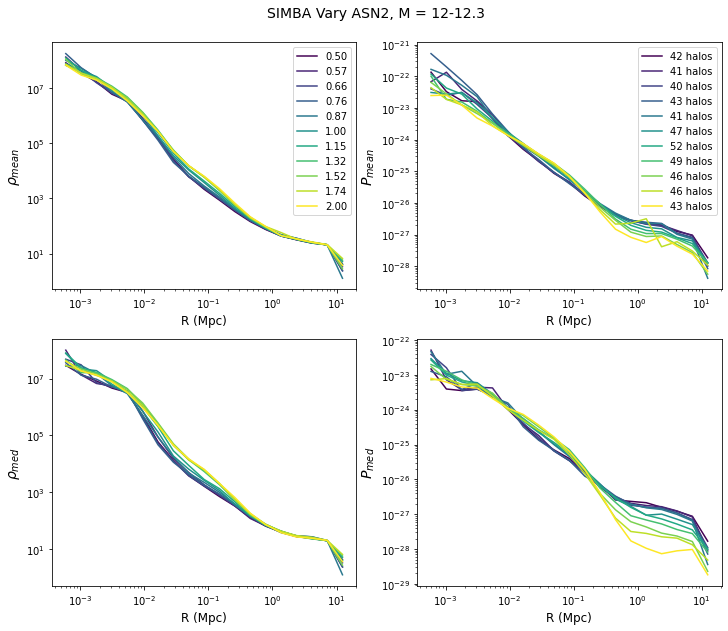

In [83]:
mass_str='12-12.3'
mh_low=10**12.+.1
mh_high=10**12.3

suite='SIMBA'

vary_str='ASN2'
vary=np.array([0.50000,0.57435,0.65975,0.75786,0.87055,1.00000,1.14870,1.31951,1.51572,1.74110,2.00000])
 
cmap=cm.get_cmap('viridis',len(vary))
colors=cmap.colors

nums=np.linspace(44,54,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

fig,axes=plt.subplots(2,2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)

    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    
    r_mpc=r/1.e3
            
    r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
    r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(5.e-4,r_mpc_cut,val_densm)
    r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
    r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(5.e-4,r_mpc_cut,val_presm)
                        
    mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
    mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
    median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
    median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
    errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
    errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
    ax0.loglog(r_mpc_cut2,mean_unnorm_densm,color=colors[j],label='%.2f'%(vary[j]))
    ax1.loglog(r_mpc_cut2,mean_unnorm_presm,color=colors[j],label='%i halos'%nprofsm)
    ax2.loglog(r_mpc_cut2,median_unnorm_densm,color=colors[j])
    ax3.loglog(r_mpc_cut2,median_unnorm_presm,color=colors[j])
ax0.set_xlabel('R (Mpc)',size=12)
ax1.set_xlabel('R (Mpc)',size=12)
ax2.set_xlabel('R (Mpc)',size=12)
ax3.set_xlabel('R (Mpc)',size=12)
ax0.set_ylabel(r'$\rho_{mean}$',size=14)
ax1.set_ylabel(r'$P_{mean}$',size=14)
ax2.set_ylabel(r'$\rho_{med}$',size=14)
ax3.set_ylabel(r'$P_{med}$',size=14)
ax0.legend()
ax1.legend()
plt.suptitle('%s Vary %s, M = %s'%(suite,vary_str,mass_str),y=0.93,size=14)
plt.savefig('./Mass_bins/vary_'+vary_str+'_'+suite+'_M_'+mass_str+'.png')
plt.show()

# 8. SIMBA, $A_{AGN2}$

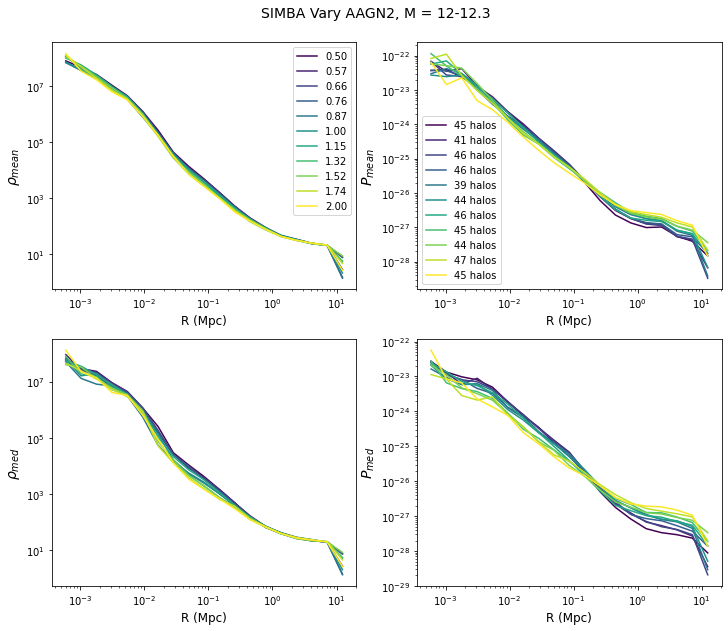

In [84]:
mass_str='12-12.3'
mh_low=10**12.+.1
mh_high=10**12.3

suite='SIMBA'

vary_str='AAGN2'
vary=np.array([0.50000,0.57435,0.65975,0.75786,0.87055,1.00000,1.14870,1.31951,1.51572,1.74110,2.00000])
 
cmap=cm.get_cmap('viridis',len(vary))
colors=cmap.colors

nums=np.linspace(55,65,11,dtype='int') #22,65,44
simulations=['1P_'+str(n) for n in nums]

fig,axes=plt.subplots(2,2,figsize=(12,10))
ax0=axes[0,0]
ax1=axes[0,1]
ax2=axes[1,0]
ax3=axes[1,1]
for j in np.arange(len(simulations)):
    sim=simulations[j]

    z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
    mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)
    
    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)

    r_mpc=r/1.e3
            
    r_mpc_cut,val_densm=profile_functions.outer_cut_multi(20,r_mpc,val_densm)
    r_mpc_cut2,val_densm=profile_functions.inner_cut_multi(5.e-4,r_mpc_cut,val_densm)
    r_mpc_cut,val_presm=profile_functions.outer_cut_multi(20,r_mpc,val_presm)
    r_mpc_cut2,val_presm=profile_functions.inner_cut_multi(5.e-4,r_mpc_cut,val_presm)
                        
    mean_unnorm_densm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_densm)
    mean_unnorm_presm=np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]),0,val_presm)
    median_unnorm_densm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_densm)
    median_unnorm_presm=np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]),0,val_presm)
        
    errup_dens_unnormm,errlow_dens_unnormm,std_dens_unnormm=profile_functions.get_errors(val_densm)
    errup_pres_unnormm,errlow_pres_unnormm,std_pres_unnormm=profile_functions.get_errors(val_presm)
            
    ax0.loglog(r_mpc_cut2,mean_unnorm_densm,color=colors[j],label='%.2f'%(vary[j]))
    ax1.loglog(r_mpc_cut2,mean_unnorm_presm,color=colors[j],label='%i halos'%nprofsm)
    ax2.loglog(r_mpc_cut2,median_unnorm_densm,color=colors[j])
    ax3.loglog(r_mpc_cut2,median_unnorm_presm,color=colors[j])
ax0.set_xlabel('R (Mpc)',size=12)
ax1.set_xlabel('R (Mpc)',size=12)
ax2.set_xlabel('R (Mpc)',size=12)
ax3.set_xlabel('R (Mpc)',size=12)
ax0.set_ylabel(r'$\rho_{mean}$',size=14)
ax1.set_ylabel(r'$P_{mean}$',size=14)
ax2.set_ylabel(r'$\rho_{med}$',size=14)
ax3.set_ylabel(r'$P_{med}$',size=14)
ax0.legend()
ax1.legend()
plt.suptitle('%s Vary %s, M = %s'%(suite,vary_str,mass_str),y=0.93,size=14)
plt.savefig('./Mass_bins/vary_'+vary_str+'_'+suite+'_M_'+mass_str+'.png')
plt.show()


Let's just explore the number of halos in different bins

1P_22 11-11.5 221
1P_22 11.5-12 210
1P_22 12-12.3 39
1P_22 12.3-13.1 29


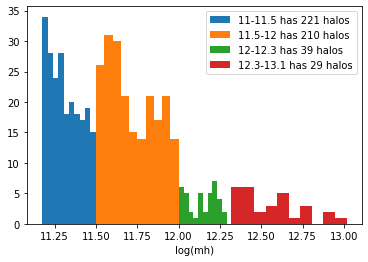

In [58]:
mass_str_arr=['11-11.5','11.5-12','12-12.3','12.3-13.1']
mh_low_arr=[10**11.,10**11.5+0.1,10**12.+0.1,10**12.3+.1]
mh_high_arr=[10**11.5,10**12.,10**12.3,10**13.1]

suite='IllustrisTNG'
sim='1P_22'

z,val_dens,bins,r,val_pres,nprofs,mh,rh=extract(sim,snap)
mh,rh,val_dens,val_pres,r=correct(z,h,mh,rh,val_dens,val_pres,r)

for m in np.arange(len(mh_low_arr)):
    mh_low=mh_low_arr[m]
    mh_high=mh_high_arr[m]
    mass_str=mass_str_arr[m]
    mhm,rhm,val_presm,val_densm,nprofsm=mhalo_cut(mh_low,mh_high,mh,rh,val_pres,val_dens,bins)
    print(sim,mass_str,len(mhm))
    plt.hist(np.log10(mhm),label='%s has %i halos'%(mass_str,len(mhm)))
plt.legend()
plt.xlabel('log(mh)')
plt.savefig('mh_4bins_histo.png')
